In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

from lightgbm import LGBMClassifier

import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# seed.txtからdataframe作成
# df_MWHBD = pd.DataFrame(columns=["SEED","M", "W", "H", "B", "D"])
# df_hwdafg = pd.DataFrame(columns=["SEED","h", "w", "d", "a", "f", "g"])
# hwdafg_line=0

# filepath="/content/drive/MyDrive/AHC/TOYOTAHC2023spring/in/"
# txt=".txt"
# for i in range(1000):
#     if i%100==99: print(i)
#     seed_num="0"*(4-len(str(i)))+str(i)
#     with open(filepath+seed_num+txt,"r",encoding="UTF-8") as f:
#         data=f.readlines()
#         firstline=data[0]
#         M,W,H,B,D= map(int, firstline.split())
#         df_MWHBD.loc[i] = [seed_num,M,W,H,B,D]
#         for p in range(1,M+1):
#             h, w, d, a, f, g = map(str, data[p].split())
#             h, w, d, a = int(h), int(w), int(d), int(a)
#             df_hwdafg.loc[hwdafg_line] = [seed_num ,h, w, d, a, f, g]
#             hwdafg_line+=1

# df_MWHBD.to_csv("MWHBD.csv",index=False)
# df_hwdafg.to_csv("hwdafg.csv",index=False)

# 上記のcsvファイルを読み込み
path="/content/drive/MyDrive/AHC/TOYOTAHC2023spring/"
df_MWHBD=pd.read_csv(path+"MWHBD.csv")
df_hwdafg=pd.read_csv(path+"hwdafg.csv")

print(df_MWHBD)
print(df_hwdafg)

     SEED   M     W    H   B     D
0       0   4  1120  680  30  1200
1       1   8  1120  680  30  1200
2       2   7  1120  680  30   600
3       3  15  1120  680  30  1200
4       4  14  1120  680  30  1200
..    ...  ..   ...  ...  ..   ...
995   995  10  1120  680  30  1200
996   996   7  1120  680  30   600
997   997   5  1120  680  30   600
998   998  17  1120  680  30  1200
999   999   8  1120  680  30  1200

[1000 rows x 6 columns]
      SEED    h    w    d  a  f  g
0        0  355  360  285  3  Y  Y
1        0  155  210  120  1  Y  Y
2        0  510  820  380  1  Y  N
3        0  370  710  330  1  Y  Y
4        1  400  820  310  1  Y  Y
...    ...  ...  ...  ... .. .. ..
9212   999  510  820  380  1  Y  Y
9213   999  320  650  220  1  N  Y
9214   999  330  530  250  2  Y  Y
9215   999  300  770  275  1  Y  N
9216   999  295  340  220  2  Y  N

[9217 rows x 7 columns]


In [3]:
df_MWHBD[["M", "W", "H", "B", "D"]]=df_MWHBD[["M", "W", "H", "B", "D"]].astype(int)
df_MWHBD[["M", "W", "H", "B", "D"]].describe()

,M,W,H,B,D
count,1000.000000,1000.0,1000.0,1000.0,1000.000000
mean,9.217000,1120.0,680.0,30.0,891.000000
std,4.344743,0.0,0.0,0.0,300.015015
min,2.000000,1120.0,680.0,30.0,600.000000
25%,6.000000,1120.0,680.0,30.0,600.000000
50%,8.000000,1120.0,680.0,30.0,600.000000
75%,12.000000,1120.0,680.0,30.0,1200.000000
max,23.000000,1120.0,680.0,30.0,1200.000000


In [4]:
df_hwdafg[["h", "w", "d", "a"]]=df_hwdafg[["h", "w", "d", "a"]].astype(int)
df_hwdafg[["h", "w", "d", "a", "f", "g"]].describe()

,h,w,d,a
count,9217.000000,9217.000000,9217.00000,9217.000000
mean,280.021374,506.854725,207.71162,1.407074
std,86.568171,196.500101,85.47505,1.325197
min,9.000000,9.000000,9.00000,1.000000
25%,205.000000,355.000000,145.00000,1.000000
50%,295.000000,510.000000,210.00000,1.000000
75%,340.000000,665.000000,280.00000,1.000000
max,560.000000,1030.000000,528.00000,29.000000


In [5]:
df_hwdafg["h_w_mul"]=df_hwdafg["h"]*df_hwdafg["w"]
df_hwdafg["h_d_mul"]=df_hwdafg["h"]*df_hwdafg["d"]
df_hwdafg["w_d_mul"]=df_hwdafg["w"]*df_hwdafg["d"]
df_hwdafg["h_w_d_mul"]=df_hwdafg["h"]*df_hwdafg["w"]*df_hwdafg["d"]

df_hwdafg["h_w_div"]=df_hwdafg["h"]/df_hwdafg["w"]
df_hwdafg["h_d_div"]=df_hwdafg["h"]/df_hwdafg["d"]
df_hwdafg["w_d_div"]=df_hwdafg["w"]/df_hwdafg["d"]

df_hwdafg["h_w_sub"]=df_hwdafg["h"]-df_hwdafg["w"]
df_hwdafg["h_d_sub"]=df_hwdafg["h"]-df_hwdafg["d"]
df_hwdafg["w_d_sub"]=df_hwdafg["w"]-df_hwdafg["d"]

df_hwdafg["fg"]=df_hwdafg["f"]+df_hwdafg["g"]

df_hwdafg

,SEED,h,w,d,a,f,g,h_w_mul,h_d_mul,w_d_mul,h_w_d_mul,h_w_div,h_d_div,w_d_div,h_w_sub,h_d_sub,w_d_sub,fg
0,0,355,360,285,3,Y,Y,127800,101175,102600,36423000,0.986111,1.245614,1.263158,-5,70,75,YY
1,0,155,210,120,1,Y,Y,32550,18600,25200,3906000,0.738095,1.291667,1.750000,-55,35,90,YY
2,0,510,820,380,1,Y,N,418200,193800,311600,158916000,0.621951,1.342105,2.157895,-310,130,440,YN
3,0,370,710,330,1,Y,Y,262700,122100,234300,86691000,0.521127,1.121212,2.151515,-340,40,380,YY
4,1,400,820,310,1,Y,Y,328000,124000,254200,101680000,0.487805,1.290323,2.645161,-420,90,510,YY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9212,999,510,820,380,1,Y,Y,418200,193800,311600,158916000,0.621951,1.342105,2.157895,-310,130,440,YY
9213,999,320,650,220,1,N,Y,208000,70400,143000,45760000,0.492308,1.454545,2.954545,-330,100,430,NY
9214,999,330,530,250,2,Y,Y,174900,82500,132500,43725000,0.622642,1.320000,2.120000,-200,80,280,YY
9215,999,300,770,275,1,Y,N,231000,82500,211750,63525000,0.389610,1.090909,2.800000,-470,25,495,YN


In [6]:
unique_df_fg=df_hwdafg.groupby(['fg'])['a'].sum().reset_index()
unique_df_fg=unique_df_fg.sort_values("a", ascending=False)
print("how many types : ", len(unique_df_fg))
print("sum(a) : ", unique_df_fg["a"].sum())
unique_df_fg.head(10)

how many types :  4
sum(a) :  12969


,fg,a
3,YY,10311
1,NY,1755
2,YN,780
0,NN,123


In [7]:
unique_df_h=df_hwdafg.groupby(['h'])['a'].sum().reset_index()
unique_df_h=unique_df_h.sort_values("a", ascending=False)
print("how many types : ", len(unique_df_h))
print("sum(a) : ", unique_df_h["a"].sum())
print("average : ", unique_df_h["a"].sum()/len(unique_df_h))
unique_df_h.head(10)

how many types :  106
sum(a) :  12969
average :  122.34905660377359


,h,a
29,190,1169
39,230,1092
62,310,535
23,170,521
70,340,463
18,150,457
60,300,408
72,350,370
68,330,352
47,250,303


In [8]:
unique_df_w=df_hwdafg.groupby(['w'])['a'].sum().reset_index()
unique_df_w=unique_df_w.sort_values("a", ascending=False)
print("how many types : ", len(unique_df_w))
print("sum(a) : ", unique_df_w["a"].sum())
print("average : ", unique_df_w["a"].sum()/len(unique_df_w))
unique_df_w.head(10)

how many types :  157
sum(a) :  12969
average :  82.60509554140127


,w,a
19,230,992
87,540,756
14,200,699
81,510,342
27,265,332
28,270,318
73,470,290
95,580,238
55,390,225
101,600,197


In [9]:
unique_df_d=df_hwdafg.groupby(['d'])['a'].sum().reset_index()
unique_df_d=unique_df_d.sort_values("a", ascending=False)
print("how many types : ", len(unique_df_d))
print("sum(a) : ", unique_df_d["a"].sum())
print("average : ", unique_df_d["a"].sum()/len(unique_df_d))
unique_df_d.head(10)

how many types :  94
sum(a) :  12969
average :  137.96808510638297


,d,a
3,40,925
49,190,711
17,100,644
45,180,585
57,220,545
61,240,524
73,290,516
55,210,501
5,55,477
23,120,444


In [10]:
unique_df_hw=df_hwdafg.groupby(['h', 'w'])['a'].sum().reset_index()
unique_df_hw=unique_df_hw.sort_values("a", ascending=False)
print("how many types : ", len(unique_df_hw))
print("sum(a) : ", unique_df_hw["a"].sum())
print("average : ", unique_df_hw["a"].sum()/len(unique_df_hw))
unique_df_hw.head(10)

how many types :  599
sum(a) :  12969
average :  21.65108514190317


,h,w,a
167,230,230,899
111,190,540,596
107,190,200,473
31,135,265,242
48,150,200,193
81,170,270,174
223,255,255,138
178,235,470,123
336,310,390,123
171,230,465,122


In [11]:
unique_df_hd=df_hwdafg.groupby(['h', 'd'])['a'].sum().reset_index()
unique_df_hd=unique_df_hd.sort_values("a", ascending=False)
print("how many types : ", len(unique_df_hd))
print("sum(a) : ", unique_df_hd["a"].sum())
print("average : ", unique_df_hd["a"].sum()/len(unique_df_hd))
unique_df_hd.head(10)

how many types :  555
sum(a) :  12969
average :  23.36756756756757


,h,d,a
153,230,40,895
98,190,55,473
104,190,180,339
105,190,190,257
28,135,125,208
44,150,120,197
390,340,330,188
166,235,190,142
73,170,140,138
212,255,60,138


In [12]:
unique_df_wd=df_hwdafg.groupby(['w', 'd'])['a'].sum().reset_index()
unique_df_wd=unique_df_wd.sort_values("a", ascending=False)
print("how many types : ", len(unique_df_wd))
print("sum(a) : ", unique_df_wd["a"].sum())
print("average : ", unique_df_wd["a"].sum()/len(unique_df_wd))
unique_df_wd.head(10)

how many types :  607
sum(a) :  12969
average :  21.365733113673805


,w,d,a
35,230,40,895
18,200,55,473
331,540,180,339
332,540,190,257
69,265,125,208
20,200,120,193
183,390,220,162
56,255,60,138
77,270,140,128
264,470,190,123


In [13]:
unique_df_hwd=df_hwdafg.groupby(['h', 'w', 'd'])['a'].sum().reset_index()
unique_df_hwd=unique_df_hwd.sort_values("a", ascending=False)
print("how many types : ", len(unique_df_hwd))
print("sum(a) : ", unique_df_hwd["a"].sum())
print("average : ", unique_df_hwd["a"].sum()/len(unique_df_hwd))
unique_df_hwd.head(10)

how many types :  726
sum(a) :  12969
average :  17.863636363636363


,h,w,d,a
189,230,230,40,895
122,190,200,55,473
126,190,540,180,339
127,190,540,190,257
34,135,265,125,208
54,150,200,120,193
260,255,255,60,138
94,170,270,140,128
397,310,390,220,123
202,235,470,190,123


In [14]:
fg='YY'
unique_df_hwd=df_hwdafg.query("fg == 'YY'").groupby(['h', 'w', 'd','fg'])['a'].sum().reset_index()
unique_df_hwd=unique_df_hwd.sort_values("a", ascending=False)
print("how many types : ", len(unique_df_hwd), "(group by "+fg+")")
print("sum(a) : ", unique_df_hwd["a"].sum())
print("average : ", unique_df_hwd["a"].sum()/len(unique_df_hwd))
unique_df_hwd.head(10)

how many types :  712 (group by YY)
sum(a) :  10311
average :  14.481741573033707


,h,w,d,fg,a
185,230,230,40,YY,719
119,190,200,55,YY,371
123,190,540,180,YY,291
124,190,540,190,YY,196
34,135,265,125,YY,169
53,150,200,120,YY,145
387,310,390,220,YY,97
255,255,255,60,YY,96
93,170,270,140,YY,95
198,235,470,190,YY,92


In [15]:
fg='NY'
unique_df_hwd=df_hwdafg.query("fg == 'NY'").groupby(['h', 'w', 'd','fg'])['a'].sum().reset_index()
unique_df_hwd=unique_df_hwd.sort_values("a", ascending=False)
print("how many types : ", len(unique_df_hwd), "(group by "+fg+")")
print("sum(a) : ", unique_df_hwd["a"].sum())
print("average : ", unique_df_hwd["a"].sum()/len(unique_df_hwd))
unique_df_hwd.head(10)

how many types :  446 (group by NY)
sum(a) :  1755
average :  3.9349775784753365


,h,w,d,fg,a
108,230,230,40,NY,123
71,190,200,55,NY,67
75,190,540,190,NY,34
141,255,255,60,NY,32
74,190,540,180,NY,32
87,205,325,70,NY,31
51,170,270,140,NY,28
44,160,235,155,NY,28
16,135,265,125,NY,28
107,223,385,100,NY,20


In [16]:
fg='YN'
unique_df_hwd=df_hwdafg.query("fg == 'YN'").groupby(['h', 'w', 'd','fg'])['a'].sum().reset_index()
unique_df_hwd=unique_df_hwd.sort_values("a", ascending=False)
print("how many types : ", len(unique_df_hwd), "(group by "+fg+")")
print("sum(a) : ", unique_df_hwd["a"].sum())
print("average : ", unique_df_hwd["a"].sum()/len(unique_df_hwd))
unique_df_hwd.head(10)

how many types :  292 (group by YN)
sum(a) :  780
average :  2.671232876712329


,h,w,d,fg,a
68,230,230,40,YN,44
17,150,200,120,YN,31
43,190,200,55,YN,27
46,190,540,190,YN,24
10,135,265,115,YN,14
69,230,465,190,YN,13
71,235,470,190,YN,13
206,340,600,330,YN,12
45,190,540,180,YN,11
11,135,265,125,YN,11


In [17]:
fg='NN'
unique_df_hwd=df_hwdafg.query("fg == 'NN'").groupby(['h', 'w', 'd','fg'])['a'].sum().reset_index()
unique_df_hwd=unique_df_hwd.sort_values("a", ascending=False)
print("how many types : ", len(unique_df_hwd), "(group by "+fg+")")
print("sum(a) : ", unique_df_hwd["a"].sum())
print("average : ", unique_df_hwd["a"].sum()/len(unique_df_hwd))
unique_df_hwd.head(10)

how many types :  74 (group by NN)
sum(a) :  123
average :  1.662162162162162


,h,w,d,fg,a
18,230,230,40,NN,9
9,190,200,55,NN,8
11,190,540,180,NN,5
36,310,390,220,NN,4
5,170,270,130,NN,4
13,200,340,120,NN,3
6,170,375,160,NN,3
8,185,580,145,NN,3
12,190,540,190,NN,3
1,130,270,110,NN,3


In [18]:
SORT_COLUMN="h"

df_sort=df_hwdafg.sort_values(SORT_COLUMN, ascending=False)[['h', 'w', 'd', 'a']]
print("descending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))

descending order sort by :  h
        h    w    d  a
2285  560  850  430  1
2992  560  850  430  1
3302  560  850  430  1
217   560  850  430  1
2328  560  850  430  1
7664  550  750  340  1
8229  550  750  340  1
8273  550  760  350  1
8308  550  750  340  1
6630  550  760  350  1
3578  550  750  340  1
4288  550  750  340  1
781   550  750  340  1
1432  550  750  340  1
5324  550  750  340  1
3836  550  750  340  1
8819  550  760  350  1
7312  550  760  350  1
3648  545  750  340  1
5134  545  750  340  1


In [19]:
SORT_COLUMN="w"

df_sort=df_hwdafg.sort_values(SORT_COLUMN, ascending=False)[['h', 'w', 'd', 'a']]
print("descending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))

descending order sort by :  w
        h     w    d  a
6352  350  1030  310  1
531   350  1030  310  1
3399  350  1030  310  1
402   350  1030  310  1
2890  300   970  280  1
4573  300   970  280  1
7688  300   970  280  1
2063  300   970  280  1
1265  300   970  280  1
6805  310   960  310  1
1976  305   960  295  1
1925  295   960  270  1
4833  305   960  295  1
5727  295   960  270  1
7654  295   960  270  1
8312  295   960  270  1
2882  295   960  270  1
8360  295   960  270  1
4006  295   960  270  1
4818  310   960  310  1


In [20]:
SORT_COLUMN="d"

df_sort=df_hwdafg.sort_values(SORT_COLUMN, ascending=False)[['h', 'w', 'd', 'a']]
print("descending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))

descending order sort by :  d
        h    w    d  a
4949  131  206  528  1
3302  560  850  430  1
217   560  850  430  1
2285  560  850  430  1
2328  560  850  430  1
2992  560  850  430  1
5492  500  820  380  1
5647  510  820  380  1
1796  510  820  380  1
1080  510  820  380  1
4245  510  820  380  1
38    500  820  380  1
9212  510  820  380  1
5300  510  820  380  1
422   510  820  380  1
1380  510  820  380  1
3966  510  820  380  1
2     510  820  380  1
5357  500  820  380  1
211   400  420  375  1


In [21]:
SORT_COLUMN="a"

df_sort=df_hwdafg.sort_values(SORT_COLUMN, ascending=False)[['h', 'w', 'd', 'a']]
print("descending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))

descending order sort by :  a
        h    w    d   a
8967  230  230   40  29
1988  230  230   40  26
5466  190  200   55  25
7529  110  330   60  25
8924  230  230   40  24
4196  190  200   55  24
7404  230  230   40  21
5760  230  230   40  19
6987  190  200   55  18
4554  125  265   65  17
3261  100  147  100  17
4823  230  230   40  17
9156  190  200   55  16
7341  190  200   55  14
312   230  230   40  14
3290  230  230   40  14
3847  230  230   40  13
2741  190  200   55  13
308   230  230   40  13
5068  230  230   40  12


In [22]:
SORT_COLUMN="h_w_mul"

df_sort=df_hwdafg.sort_values(SORT_COLUMN, ascending=False)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("descending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))
# print()
# df_sort=df_hwdafg.sort_values(SORT_COLUMN)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
# print("ascending order sort by : ", SORT_COLUMN)
# print(df_sort.head(20))

descending order sort by :  h_w_mul
      h_w_mul    h    w    d  a
217    476000  560  850  430  1
3302   476000  560  850  430  1
2992   476000  560  850  430  1
2285   476000  560  850  430  1
2328   476000  560  850  430  1
1809   430000  500  860  370  1
4647   430000  500  860  370  1
4435   430000  500  860  370  1
1895   430000  500  860  370  1
5470   430000  500  860  370  1
2558   430000  500  860  370  1
2978   430000  500  860  370  1
4967   430000  500  860  370  1
8803   430000  500  860  370  1
1697   430000  500  860  370  1
6924   430000  500  860  370  1
4580   430000  500  860  370  1
1848   430000  500  860  370  1
4463   430000  500  860  370  1
9176   430000  500  860  370  1


In [23]:
SORT_COLUMN="h_d_mul"

df_sort=df_hwdafg.sort_values(SORT_COLUMN, ascending=False)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("descending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))
# print()
# df_sort=df_hwdafg.sort_values(SORT_COLUMN)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
# print("ascending order sort by : ", SORT_COLUMN)
# print(df_sort.head(20))

descending order sort by :  h_d_mul
      h_d_mul    h    w    d  a
3302   240800  560  850  430  1
2328   240800  560  850  430  1
217    240800  560  850  430  1
2285   240800  560  850  430  1
2992   240800  560  850  430  1
422    193800  510  820  380  1
3966   193800  510  820  380  1
5300   193800  510  820  380  1
1080   193800  510  820  380  1
9212   193800  510  820  380  1
1796   193800  510  820  380  1
5647   193800  510  820  380  1
4245   193800  510  820  380  1
1380   193800  510  820  380  1
2      193800  510  820  380  1
8273   192500  550  760  350  1
8819   192500  550  760  350  1
6630   192500  550  760  350  1
7312   192500  550  760  350  1
5357   190000  500  820  380  1


In [24]:
SORT_COLUMN="w_d_mul"

df_sort=df_hwdafg.sort_values(SORT_COLUMN, ascending=False)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("descending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))
# print()
# df_sort=df_hwdafg.sort_values(SORT_COLUMN)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
# print("ascending order sort by : ", SORT_COLUMN)
# print(df_sort.head(20))

descending order sort by :  w_d_mul
      w_d_mul    h     w    d  a
3302   365500  560   850  430  1
2328   365500  560   850  430  1
2285   365500  560   850  430  1
2992   365500  560   850  430  1
217    365500  560   850  430  1
8351   320625  500   855  375  1
531    319300  350  1030  310  1
6352   319300  350  1030  310  1
402    319300  350  1030  310  1
3399   319300  350  1030  310  1
7516   318200  500   860  370  1
6924   318200  500   860  370  1
6935   318200  500   860  370  1
1144   318200  500   860  370  1
1895   318200  500   860  370  1
5470   318200  500   860  370  1
8803   318200  500   860  370  1
7691   318200  500   860  370  1
4720   318200  500   860  370  1
4435   318200  500   860  370  1


In [25]:
SORT_COLUMN="h_w_d_mul"

df_sort=df_hwdafg.sort_values(SORT_COLUMN, ascending=False)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("descending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))
print()
df_sort=df_hwdafg.sort_values(SORT_COLUMN)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("ascending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))

descending order sort by :  h_w_d_mul
      h_w_d_mul    h    w    d  a
2992  204680000  560  850  430  1
3302  204680000  560  850  430  1
2328  204680000  560  850  430  1
217   204680000  560  850  430  1
2285  204680000  560  850  430  1
8351  160312500  500  855  375  1
1809  159100000  500  860  370  1
1144  159100000  500  860  370  1
6466  159100000  500  860  370  1
9176  159100000  500  860  370  1
1269  159100000  500  860  370  1
1697  159100000  500  860  370  1
4647  159100000  500  860  370  1
5994  159100000  500  860  370  1
6261  159100000  500  860  370  1
4967  159100000  500  860  370  1
4463  159100000  500  860  370  1
5177  159100000  500  860  370  1
4720  159100000  500  860  370  1
7691  159100000  500  860  370  1

ascending order sort by :  h_w_d_mul
      h_w_d_mul    h    w   d   a
4092        729    9    9   9   1
1762        729    9    9   9   1
1891        729    9    9   9   1
7110        729    9    9   9   1
6427        729    9    9   9   1
9036  

In [26]:
SORT_COLUMN="h_w_div"

df_sort=df_hwdafg.sort_values(SORT_COLUMN, ascending=False)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("descending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))
print()
df_sort=df_hwdafg.sort_values(SORT_COLUMN)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("ascending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))

descending order sort by :  h_w_div
       h_w_div    h    w    d   a
8918  1.035714  145  140  360   3
5582  1.035714  145  140  360   1
5243  1.035714  145  140  360   6
2280  1.035714  145  140  360   1
4608  1.000000  230  230   40   1
3843  1.000000  230  230   40   1
373   1.000000  255  255   60   2
3881  1.000000  230  230   40   1
3853  1.000000  110  110  100   2
3847  1.000000  230  230   40  13
3822  1.000000  230  230   40   1
3806  1.000000  230  230   40   8
3796  1.000000  255  255   60   2
3795  1.000000  230  230   40   1
3775  1.000000  255  255   60   1
3750  1.000000  255  255   60   1
3748  1.000000  110  110  100   1
3681  1.000000  230  230   40   4
3891  1.000000  230  230   40   1
3906  1.000000  230  230   40   2

ascending order sort by :  h_w_div
       h_w_div   h    w   d  a
3225  0.085890  70  815  70  1
6222  0.085890  70  815  70  1
6915  0.085890  70  815  70  1
8975  0.085890  70  815  70  6
468   0.109375  70  640  70  2
1150  0.109375  70  640  70 

In [27]:
SORT_COLUMN="h_d_div"

df_sort=df_hwdafg.sort_values(SORT_COLUMN, ascending=False)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("descending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))
print()
df_sort=df_hwdafg.sort_values(SORT_COLUMN)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("ascending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))

descending order sort by :  h_d_div
      h_d_div    h    w   d   a
6029     7.60  190  195  25   1
5138     7.60  190  195  25   1
5319     7.60  190  195  25   1
7222     7.60  190  195  25   1
4549     7.60  190  195  25   1
2779     7.60  190  195  25   1
6775     7.60  190  195  25   3
1731     7.60  190  195  25   1
1510     7.60  190  195  25   4
2941     7.60  190  195  25   2
4946     7.60  190  195  25   2
1930     7.00  175  190  25   1
8999     7.00  175  190  25  12
5889     6.84  171  189  25   9
4997     6.84  171  189  25   1
8255     6.84  171  189  25   1
6269     6.84  171  189  25   2
8711     6.84  171  189  25   3
3955     6.84  171  189  25   2
5234     6.40  160  365  25   1

ascending order sort by :  h_d_div
       h_d_div    h    w    d  a
4949  0.248106  131  206  528  1
2280  0.402778  145  140  360  1
8918  0.402778  145  140  360  3
5243  0.402778  145  140  360  6
5582  0.402778  145  140  360  1
4310  0.772727  170  170  220  2
8769  0.772727  170  170 

In [28]:
SORT_COLUMN="w_d_div"

df_sort=df_hwdafg.sort_values(SORT_COLUMN, ascending=False)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("descending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))
print()
df_sort=df_hwdafg.sort_values(SORT_COLUMN)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("ascending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))

descending order sort by :  w_d_div
        w_d_div    h    w   d  a
5372  14.600000  160  365  25  2
5234  14.600000  160  365  25  1
9201  13.571429   75  475  35  2
8867  13.571429   75  475  35  1
2831  13.571429   75  475  35  1
420   13.571429   75  475  35  2
6370  13.571429   75  475  35  1
4500  13.250000  190  530  40  1
7194  13.250000  190  530  40  2
2787  13.250000  190  530  40  1
4241  13.250000  190  530  40  1
6531  13.250000  190  530  40  1
976   13.250000  190  530  40  1
1773  13.250000  190  530  40  6
3225  11.642857   70  815  70  1
6222  11.642857   70  815  70  1
6915  11.642857   70  815  70  1
8975  11.642857   70  815  70  6
1588  10.222222   80  460  45  5
856   10.222222   80  460  45  1

ascending order sort by :  w_d_div
       w_d_div    h    w    d  a
2280  0.388889  145  140  360  1
5582  0.388889  145  140  360  1
5243  0.388889  145  140  360  6
8918  0.388889  145  140  360  3
4949  0.390152  131  206  528  1
8769  0.772727  170  170  220  1
7758

In [29]:
SORT_COLUMN="h_w_sub"

df_sort=df_hwdafg.sort_values(SORT_COLUMN, ascending=False)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("descending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))
print()
df_sort=df_hwdafg.sort_values(SORT_COLUMN)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("ascending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))

descending order sort by :  h_w_sub
      h_w_sub    h    w    d  a
5582        5  145  140  360  1
8918        5  145  140  360  3
2280        5  145  140  360  1
5243        5  145  140  360  6
3952        0  230  230   40  1
4018        0  255  255   60  1
408         0  230  230   40  1
3987        0  230  230   40  1
3963        0  350  350  200  1
3943        0  230  230  155  1
4038        0  230  230   40  1
3940        0  230  230   40  1
3906        0  230  230   40  2
3898        0  230  230   40  1
3891        0  230  230   40  1
3881        0  230  230   40  1
3853        0  110  110  100  2
419         0  230  230   40  5
4024        0  230  230   40  1
4043        0  350  350  200  1

ascending order sort by :  h_w_sub
      h_w_sub    h     w    d  a
6222     -745   70   815   70  1
3225     -745   70   815   70  1
6915     -745   70   815   70  1
8975     -745   70   815   70  6
531      -680  350  1030  310  1
402      -680  350  1030  310  1
3399     -680  350  1030 

In [30]:
SORT_COLUMN="h_d_sub"

df_sort=df_hwdafg.sort_values(SORT_COLUMN, ascending=False)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("descending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))
print()
df_sort=df_hwdafg.sort_values(SORT_COLUMN)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("ascending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))

descending order sort by :  h_d_sub
      h_d_sub    h    w    d  a
8159      260  395  545  135  1
22        260  395  545  135  1
8715      255  385  550  130  1
2031      255  385  550  130  1
185       255  375  505  120  1
6331      255  385  550  130  1
1011      255  385  550  130  1
8149      255  385  550  130  2
8318      255  385  550  130  3
5495      255  385  550  130  3
6928      255  385  550  130  2
5515      255  375  505  120  1
4771      255  385  550  130  2
3622      255  385  550  130  2
7991      225  465  470  240  1
7258      225  465  470  240  1
3606      225  465  470  240  1
2892      225  465  470  240  1
4702      225  465  470  240  1
6355      225  465  470  240  1

ascending order sort by :  h_d_sub
      h_d_sub    h    w    d  a
4949     -397  131  206  528  1
5243     -215  145  140  360  6
5582     -215  145  140  360  1
2280     -215  145  140  360  1
8918     -215  145  140  360  3
9024      -50  170  170  220  1
7758      -50  170  170  220  3


In [31]:
SORT_COLUMN="w_d_sub"

df_sort=df_hwdafg.sort_values(SORT_COLUMN, ascending=False)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("descending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))
print()
df_sort=df_hwdafg.sort_values(SORT_COLUMN)[[SORT_COLUMN,'h', 'w', 'd', 'a']]
print("ascending order sort by : ", SORT_COLUMN)
print(df_sort.head(20))

descending order sort by :  w_d_sub
      w_d_sub    h     w    d  a
8975      745   70   815   70  6
3225      745   70   815   70  1
6222      745   70   815   70  1
6915      745   70   815   70  1
531       720  350  1030  310  1
3399      720  350  1030  310  1
402       720  350  1030  310  1
6352      720  350  1030  310  1
4298      700  210   850  150  1
162       700  210   850  150  1
1725      700  210   850  150  2
716       700  210   850  150  1
4037      700  210   850  150  1
6282      690  295   960  270  1
1685      690  295   960  270  1
6067      690  295   960  270  1
281       690  335   890  200  1
2669      690  295   960  270  1
949       690  295   960  270  1
4006      690  295   960  270  1

ascending order sort by :  w_d_sub
      w_d_sub    h    w    d  a
4949     -322  131  206  528  1
2280     -220  145  140  360  1
5582     -220  145  140  360  1
8918     -220  145  140  360  3
5243     -220  145  140  360  6
7758      -50  170  170  220  3
8769      -

In [32]:
df_a_sum=df_hwdafg.groupby(["SEED"])['a'].sum().reset_index()
df_hwda=df_hwdafg[['SEED','h', 'w', 'd', 'a']]
df_hwda["hwda"]=df_hwda["h"]*df_hwda["w"]*df_hwda["d"]*df_hwda["a"]
df_hwda["hwa"]=df_hwda["h"]*df_hwda["w"]*df_hwda["a"]
df_hwda["hda"]=df_hwda["h"]*df_hwda["d"]*df_hwda["a"]
df_hwda["wda"]=df_hwda["w"]*df_hwda["d"]*df_hwda["a"]
df_hwda_sum=df_hwda.groupby(["SEED"])["hwda","hwa","hda","wda"].sum().reset_index()

df_MWHBD["sum_a"]=df_a_sum["a"]
df_MWHBD["sum_volume_of_luggage"]=df_hwda_sum["hwda"]
# df_MWHBD["sum_area_hw_of_luggage"]=df_hwda_sum["hwa"]
# df_MWHBD["sum_area_hd_of_luggage"]=df_hwda_sum["hda"]
# df_MWHBD["sum_area_wd_of_luggage"]=df_hwda_sum["wda"]
df_MWHBD["capacity"]=(df_MWHBD["H"]*df_MWHBD["W"]-4*df_MWHBD["B"]**2)*df_MWHBD["D"]
df_MWHBD["filling_rate"]=df_MWHBD["sum_volume_of_luggage"]/df_MWHBD["capacity"]
df_MWHBD.describe()

,SEED,M,W,H,B,D,sum_a,sum_volume_of_luggage,capacity,filling_rate
count,1000.000000,1000.000000,1000.0,1000.0,1000.0,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000
mean,499.500000,9.217000,1120.0,680.0,30.0,891.000000,12.969000,4.001733e+08,6.753780e+08,0.594581
std,288.819436,4.344743,0.0,0.0,0.0,300.015015,7.206523,1.673361e+08,2.274114e+08,0.146011
min,0.000000,2.000000,1120.0,680.0,30.0,600.000000,2.000000,1.404664e+08,4.548000e+08,0.308853
25%,249.750000,6.000000,1120.0,680.0,30.0,600.000000,7.000000,2.725144e+08,4.548000e+08,0.480355
50%,499.500000,8.000000,1120.0,680.0,30.0,600.000000,11.500000,3.532000e+08,4.548000e+08,0.593003
75%,749.250000,12.000000,1120.0,680.0,30.0,1200.000000,17.000000,5.195430e+08,9.096000e+08,0.719280
max,999.000000,23.000000,1120.0,680.0,30.0,1200.000000,43.000000,7.787554e+08,9.096000e+08,0.892262


In [33]:
unique_df_sum_a=df_MWHBD['sum_a'].value_counts(ascending=False)
print("sum_a, count")
unique_df_sum_a

sum_a, count


8     84
7     75
6     68
10    59
11    57
12    55
14    54
5     49
13    48
9     47
16    39
15    38
17    34
4     32
19    31
18    30
21    28
20    23
3     23
22    18
28    15
23    14
27    12
25    11
24     9
26     6
30     6
2      6
29     6
31     4
38     4
33     4
40     3
32     2
37     2
43     1
34     1
39     1
36     1
Name: sum_a, dtype: int64

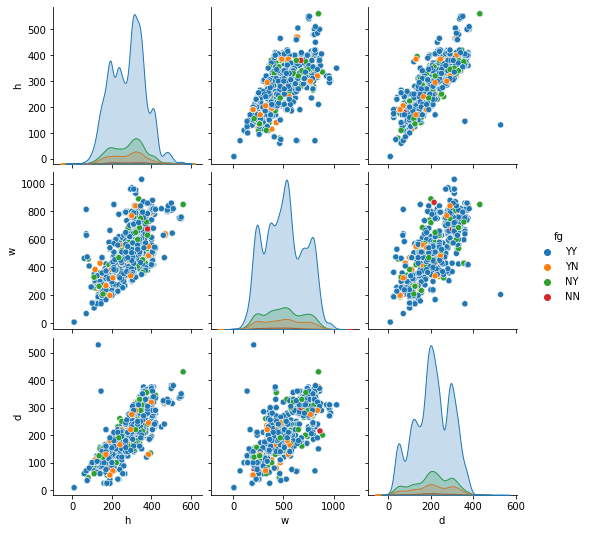

In [34]:
sns.pairplot(df_hwdafg[["h", "w", "d","fg"]], hue="fg")

In [47]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

fig = px.scatter_3d(df_hwdafg, x='h', y='w', z='d', color='fg')
fig.update_traces(marker=dict(size=2, opacity=0.5))

fig.show()

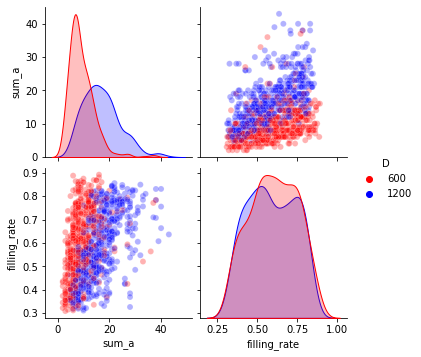

In [35]:
sns.pairplot(df_MWHBD[["D", "sum_a", "filling_rate"]], hue="D", palette={600: 'red',1200: 'blue'},plot_kws={'alpha': 0.3})

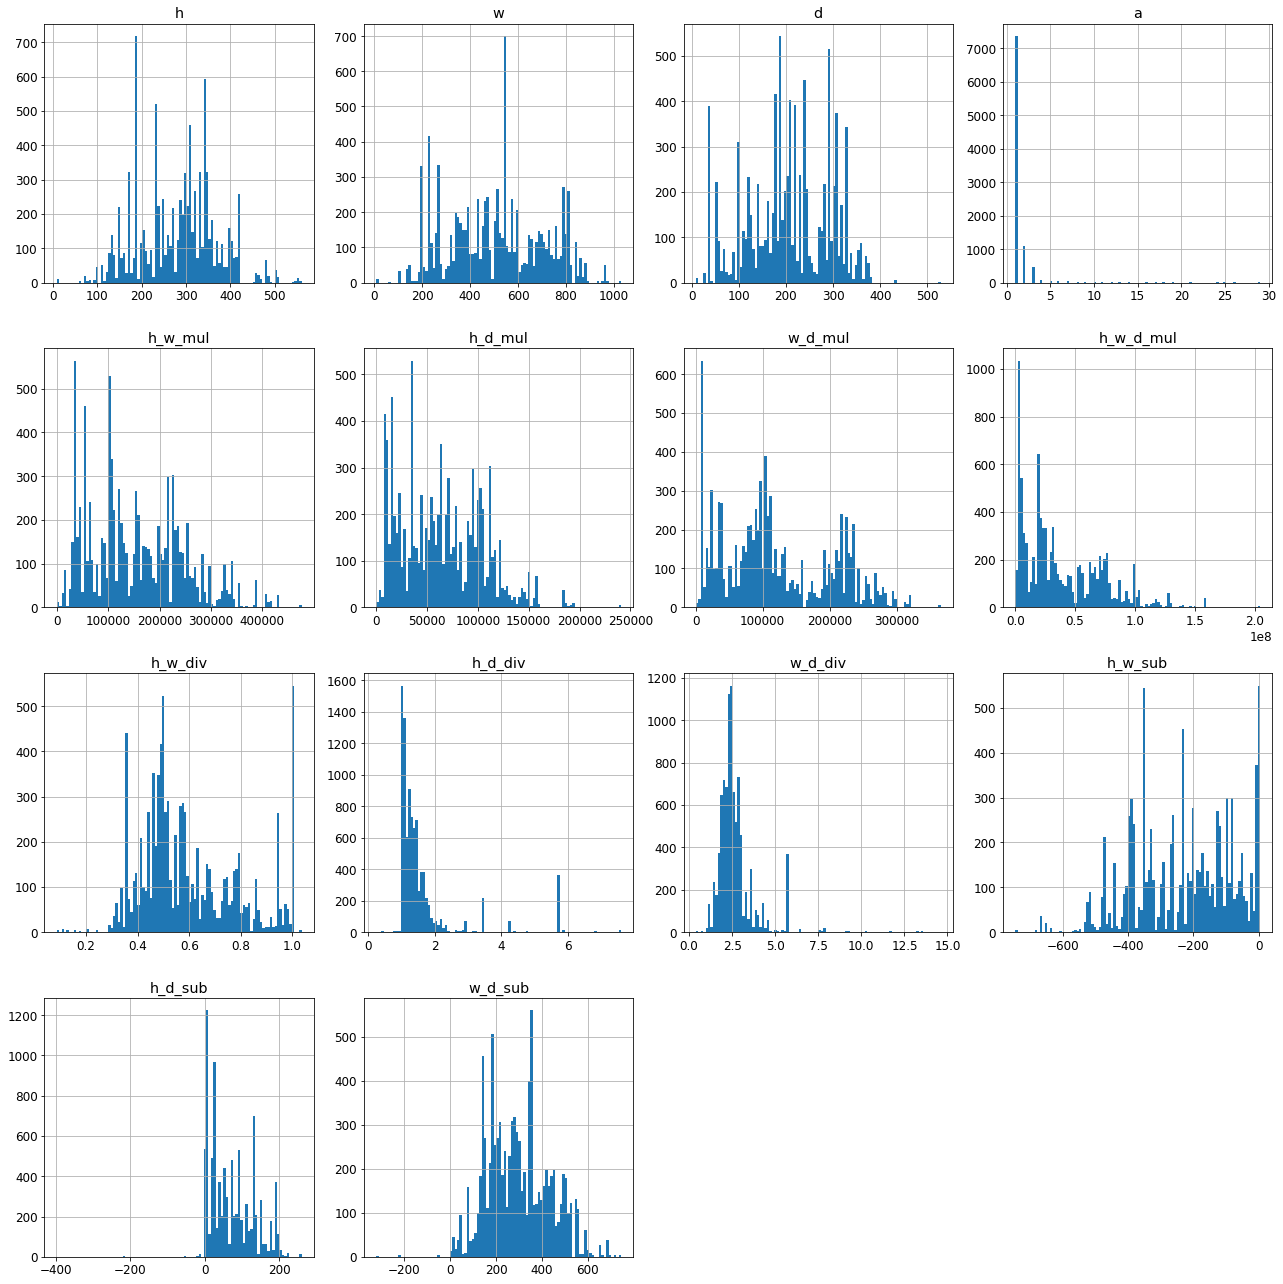

In [36]:
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(18,18))
ax = fig.gca()
df_hwdafg.drop("SEED",axis=1).hist(ax=ax,bins=100)
plt.tight_layout()
plt.show()